# CREDIT CARD KAAGLE DATASET

In [48]:
import os
import sys
import csv
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from scipy.stats import chi2, norm
from scipy.integrate import quad
from scipy.special import erfinv

from sklearn.metrics.pairwise import pairwise_distances

import torch
import falkon

sys.path.insert(0, "../notebooks")
from plot_utils import plot_one_t


In [2]:
DATA_PATH = '../data/creditcard.csv'
df = pd.read_csv(DATA_PATH)

#normalize Time and Amount features
df['Time']   = (df['Time'] - df['Time'].mean()) / df['Time'].std()
df['Amount'] = (df['Amount'] - df['Amount'].mean()) / df['Amount'].std()

df_ref  = df[df['Class']==0]
df_data = df[df['Class']==1]

N_REF_TOT  = len(df_ref)
N_DATA_TOT = len(df_data)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996580,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996580,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342474,0
2,-1.996558,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160684,0
3,-1.996558,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996537,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [3]:
print(f'total number of transaction (data size): {N_REF_TOT+N_DATA_TOT}')
print(f'total number of reference transaction: {N_REF_TOT}')
print(f'total number of anomalous transaction: {N_DATA_TOT}, \n(ratio: {(N_DATA_TOT/N_REF_TOT)*100:.3f})%')

total number of transaction (data size): 284807
total number of reference transaction: 284315
total number of anomalous transaction: 492, 
(ratio: 0.173)%


### separate the features with the target

In [4]:
Ref  = df_ref[df_ref.columns[:-1]].to_numpy()
Data = df_data[df_data.columns[:-1]].to_numpy()

Target_Ref  = df_ref['Class'].to_numpy()
Target_Data = df_data['Class'].to_numpy()

print('feature reference shape:',Ref.shape)
print('feature data shape:\t',Data.shape)


feature reference shape: (284315, 30)
feature data shape:	 (492, 30)


### euclidean pair-wise distance

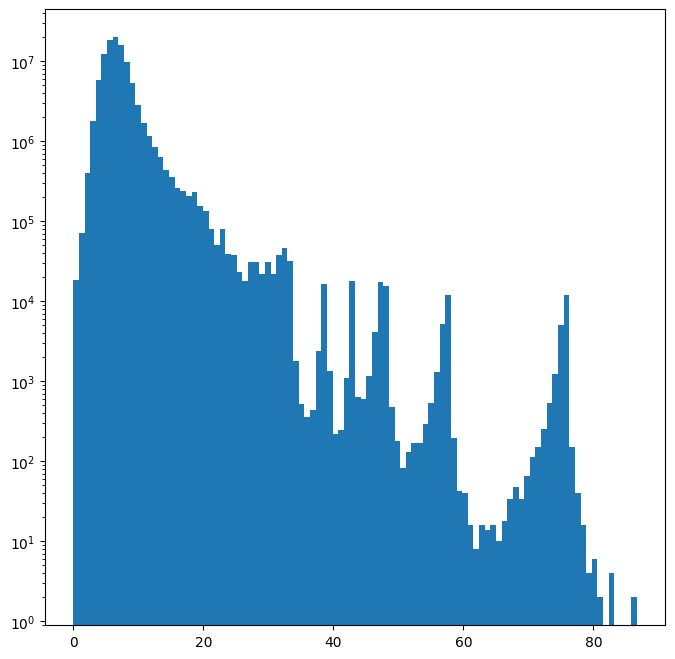

9.504345824976589
6.537063066684784


In [9]:
idx= np.random.choice(Ref.shape[0], 10_000, replace=False)
subset = Ref[idx]

distances = pairwise_distances(subset, metric='euclidean')
plt.figure(figsize=(8,8))
plt.hist(distances.ravel(), bins=100, density=False)
plt.yscale('log')
plt.show()

quantile = np.quantile(distances, 0.90)
print(quantile)
print(np.median(distances))
del distances

## Define a model

In [10]:
# Statistics
N_REF      = 3_000#10_000
N_BKG      = 1_000
N_SIG      = 0  
# Samples weights N_D/N_R
N_R        = N_REF
N_D        = N_BKG

# select a random chosen subset of the dataset
idx_ref = np.random.choice(Ref.shape[0], N_REF+N_BKG, replace=False)
idx_sig = np.random.choice(Data.shape[0], N_SIG, replace=False)

feature_ref  = torch.from_numpy(Ref[idx_ref[:N_REF], :])
feature_bkg  = torch.from_numpy(Ref[idx_ref[N_REF:], :])
feature_sig  = torch.from_numpy(Data[idx_sig, :])
feature_data = torch.cat((feature_bkg, feature_sig), dim=0)

target_ref  = torch.zeros((N_REF, 1), dtype=torch.float64)
target_data = torch.ones((N_BKG + N_SIG, 1), dtype=torch.float64)

feature = torch.cat((feature_ref, feature_data), axis=0)
target  = torch.cat((target_ref, target_data), axis=0)

print('feature shape:', feature.shape)
print('feature shape:', target.shape)


feature shape: torch.Size([4000, 30])
feature shape: torch.Size([4000, 1])


In [11]:
sigma = quantile

logflk_opt = falkon.FalkonOptions(cg_tolerance=np.sqrt(1e-7), keops_active='no', use_cpu=False, debug = False)
logflk_kernel = falkon.kernels.GaussianKernel(sigma=sigma,  opt=logflk_opt)
logloss = falkon.gsc_losses.WeightedCrossEntropyLoss(logflk_kernel, neg_weight = N_D/N_R)

config = {
    "kernel"       : logflk_kernel,
    "M"            : 2000,
    "penalty_list" : [1e-7],
    "iter_list"    : [10_000],
    "options"      : logflk_opt,
    "seed"         : None,
    "loss"         : logloss,
}

logflk = falkon.LogisticFalkon(**config)

In [11]:
logflk.fit(feature, target)
ref_pred, data_pred = logflk.predict((feature_ref)), logflk.predict(feature_data)
diff = N_D/N_R *torch.sum(1 - torch.exp(ref_pred))
t = 2 * (diff + torch.sum(data_pred).item()).item()
print(t)

Iteration 0 - penalty 1.000000e-07 - sub-iterations 10000
1417.615941316837


## Learn_t function

In [13]:
def learn_t(config_json: dict):
    
    '''GENERATE DATASET'''
    # Statistics
    N_REF      = config_json['N_REF']
    N_BKG      = config_json['N_BKG']
    N_SIG      = config_json['N_SIG']
    # HYPER-PARAMS
    M = config_json['M']
    l = config_json['l']
    sigma = config_json['sigma']
    
    # np.random.seed(time.time())

    # select a random chosen subset of the dataset
    idx_ref = np.random.choice(Ref.shape[0], N_REF+N_BKG, replace=False)
    idx_sig = np.random.choice(Data.shape[0], N_SIG, replace=False)

    feature_ref  = torch.from_numpy(Ref[idx_ref[:N_REF], :])
    feature_bkg  = torch.from_numpy(Ref[idx_ref[N_REF:], :])
    feature_sig  = torch.from_numpy(Data[idx_sig, :])
    feature_data = torch.cat((feature_bkg, feature_sig), dim=0)

    target_ref  = torch.zeros((N_REF, 1), dtype=torch.float64)
    target_data = torch.ones((N_BKG + N_SIG, 1), dtype=torch.float64)

    feature = torch.cat((feature_ref, feature_data), axis=0)
    target  = torch.cat((target_ref, target_data), axis=0)

    # print('feature shape:', feature.shape)
    # print('feature shape:', target.shape)

    '''DEFINE THE MODEL'''
    
    logflk_opt = falkon.FalkonOptions(cg_tolerance=np.sqrt(1e-7), keops_active='no', use_cpu=False, debug = False)
    logflk_kernel = falkon.kernels.GaussianKernel(sigma=sigma,  opt=logflk_opt)
    logloss = falkon.gsc_losses.WeightedCrossEntropyLoss(logflk_kernel, neg_weight = N_BKG/N_REF)

    config = {
        "kernel"       : logflk_kernel,
        "M"            : M,
        "penalty_list" : [l],
        "iter_list"    : [1_000_000],
        "options"      : logflk_opt,
        "seed"         : None,
        "loss"         : logloss,
    }

    logflk = falkon.LogisticFalkon(**config)
    
    '''TRAIN'''
    
    logflk.fit(feature, target)
    ref_pred, data_pred = logflk.predict(feature_ref), logflk.predict(feature_data)
    diff = N_BKG/N_REF *torch.sum(1 - torch.exp(ref_pred))
    t = 2 * (diff + torch.sum(data_pred).item()).item()
    
    return t
    

create a function which has the train loop inside and save the entire list of t in a file with also the single toy training time. it can return the t_list. try with saving such as Nik files 

problem: bisognerebbe creare una funzione che genera i dati e che prende il seed.. in questo modo allora si può chiamare la funzione dentro un'altra ecc..

al momento non si riesce erchè viene generato un solo dataset e verrebbe utilizzato sempre quello per allenare.

### Plot t distribution 

In [70]:
config = {
    "N_REF" : 5000,
    "N_BKG" : 1000,
    "N_SIG" : 0,
    "M"     : 1500,
    "l"     : 1e-8,
    "sigma" : sigma,
}

t_list=[]
toy = 50

for _ in range(toy):
    t = learn_t(config_json=config)
    t_list.append(t)

Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000


Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
Iteration 0 - penalty 1.000000e-08 - sub-iterations 1000

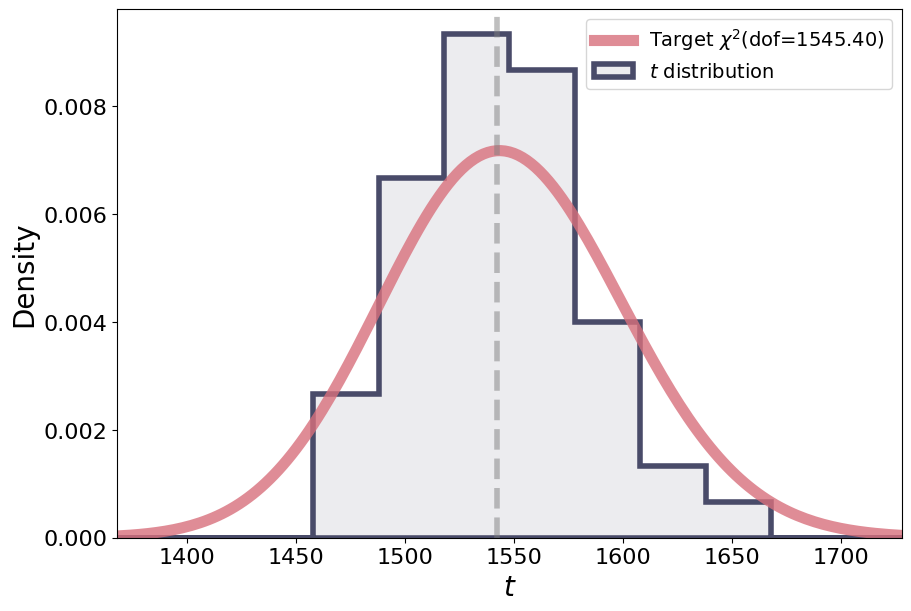

In [71]:
df_fit, loc, scale = chi2.fit(t_list, floc=0, fscale=1)
t_ref_bins  = np.arange(int(np.min(t_list))-100, int(np.max(t_list))+100, 30)
xgrid_ref   = np.arange(int(np.min(t_list))-100, int(np.max(t_list))+100, 2)

ref_chi2 = chi2(df=df_fit)

plot_one_t(
    t_distribution  = t_list,
    t_bins          = t_ref_bins,
    chi2            = ref_chi2,
    chi2_grid       = xgrid_ref,
    show_hist       = True,
    show_error      = False,
    compute_rate    = False,
    err_marker      = "o",
    err_markersize  = 10,
    err_capsize     = 5,
    err_elinewidth  = 4,
    err_capthick    = 4,
    err_color       = "black",
    figsize         = (9, 6),
    fontsize        = 20,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    hist_ecolor     = ("#494B69", 1.0),
    hist_fcolor     = ("#494B69", 0.1),
    chi2_color      = ("#D8707C", 0.8),
    hist_lw         = 4,
    chi2_lw         = 8,
    hist_type       = "stepfilled",
    hist_label      = "$\it{t}$ distribution",
    chi2_label      = "Target $\chi^2$(dof=%.2f)"%(df_fit),
    xlabel          = r"$t$",
    ylabel          = "Density",
    show_plot       = True,
    save_plot       = False,
    plot_name       = "t_distribution",
    # plot_path       = PLOT_PATH,
    plot_format     = "png",
    return_fig      = False,
    plot_w          = False,
    wclip           = None,
)

### KS-test for $\chi^2$ fit

In [72]:
## KS test statistic for the compatibility of p(t) and chi2 fit
ks_statistic, ks_p_value = stats.kstest(t_list, "chi2", args=(df_fit,))
print('KS p-value: ',ks_p_value)
print('KS test: ',ks_statistic*100, '%')

KS p-value:  0.3761629552237945
KS test:  12.577401834962675 %


## Hyperparameter tuning

In [49]:
# toys   = 50
# M_list = [500, 1000, 1500, 2000]
# l_list = [1e-8]
# sigma  = sigma

config = {
    'toys'   : 50,
    'OUTPUT_PATH' : "/home/ubuntu/NPLM-Falkon/output/bank_data/",
    "N_REF" : 3000,
    "N_BKG" : 1000,
    "N_SIG" : 0,
    'M_list' : [500, 1000, 1500, 2000],
    'l_list' : [1e-6],
    "sigma" : sigma,    
}


def run_toys(config):
    """
    return list of t values and save the results in csv files
    """
    toys = config['toys']
    M_list = config['M_list']
    l_list = config['l_list']
    
    current_date  = str(datetime.now().year)        + "_"
    current_date += str(datetime.now().month)       + "_"
    current_date += str(datetime.now().day)         + "_"
    current_date += str(datetime.now().hour)        + "-"
    current_date += str(datetime.now().minute)      
    OUTPUT_PATH = config['OUTPUT_PATH'] + current_date
    
    os.makedirs(OUTPUT_PATH, exist_ok=True)

    t_list = []
    for l in l_list:
        t_M_list = []
        for M in M_list:
            t_list_tmp = []
            config_train = {
                "N_REF" : config["N_REF"],
                "N_BKG" : config["N_BKG"],
                "N_SIG" : config["N_SIG"],
                "M"     : M,
                "l"     : l,
                "sigma" : config["sigma"],
                }
            for _ in range(toys):
                train_start = time.time()
                t = learn_t(config_train)
                train_stop = time.time()
                t_list_tmp.append(t)
                
                FILE_NAME = "/ttest_time_"+str(l) +"_"+ str(M) + ".csv"
                
                ti = time.time()
                with open(OUTPUT_PATH + FILE_NAME, "a", newline="\n") as f:
                    writer = csv.writer(f, dialect="excel" ,delimiter="\t")
                    writer.writerow([t, (train_stop-train_start)])
                tf = time.time()
                # print(tf-ti)
                
                '''SAVE PLOT'''
                
                
            t_M_list.append(t_list_tmp)
            del t_list_tmp
        t_list.append(t_M_list)
        del t_M_list
    
    return t_list, current_date
    

t_list, output_date = run_toys(config)
    

Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000


0.0002760887145996094
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000
0.00015044212341308594
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000
0.0001404285430908203
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000
0.00014543533325195312
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000
0.00016355514526367188
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000
0.00015664100646972656
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000
0.00014495849609375
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000
0.00014448165893554688
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000
0.00014257431030273438
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000
0.0001480579376220703
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000
0.00014066696166992188
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000
0.00013637542724609375
Iteration 0 - penalty 1.000000e-06 - sub-iterations 1000000
0.00014543

## Read and evaluate the KS p-value

ci vuole una funzione che data una combinazione di l e M si salvi la distriuzione di t e restituisca il plot e salvi il KS p-value

In [142]:
def extract_l_M(file):
    file = file.replace("ttest_time_", "")
    file = file.replace(".csv", "")
    file = file.replace("_", " ")
    l = file.split()[0]
    m = file.split()[1]
    # l_listtt.append(float(l)); M_listtt.append(int(m))

    # return list(set(l_listtt)), list(set(M_listtt))
    return float(l), int(m)
    
ll, mm = extract_l_M("ttest_time_1e-08_1500.csv")
print(ll, mm)

1e-08 1500


In [100]:
def read_and_save(date=output_date):
    l_list = config['l_list']
    M_list = config['M_list']
    c = list(itertools.product(l_list,M_list))

    PATH = config['OUTPUT_PATH'] + output_date
    # path = "/home/ubuntu/NPLM-Falkon/output/bank_data/2024_2_22_13-0"

    for l,m in c:
        with open(PATH + "/ttest_time_"+str(l)+"_"+str(m)+".csv") as f:
            t_list = np.array([float(row.split()[0]) for row in f])
            
            # print(path + "/ttest_time_"+str(l)+"_"+str(m)+".csv")
            # print(t_list)
        dof_fit, _, _ = chi2.fit(t_list, floc=0, fscale=1)
        ks_statistic, ks_p_value = stats.kstest(t_list, "chi2", args=(dof_fit,))
        # print('KS p-value: ',ks_p_value)
        # print('KS test: ',ks_statistic*100, '%')     
        print(f'KS p-value for ({m}, {l}): {ks_p_value:.2f} \t DOF of chi2: {dof_fit:.2f}')   


In [143]:
def read_and_save(date=output_date):

    PATH = config['OUTPUT_PATH']
    for dir in os.listdir(PATH):
        for file in os.listdir(PATH+str(dir)):
            with open(PATH + str(dir) +'/'+ str(file)) as f:
                t_list = np.array([float(row.split()[0]) for row in f])

            dof_fit, _, _ = chi2.fit(t_list, floc=0, fscale=1)
            ks_statistic, ks_p_value = stats.kstest(t_list, "chi2", args=(dof_fit,))
            l,m = extract_l_M(file)
            print(f'KS p-value for ({m}, {l}): {ks_p_value:.2f} \t DOF of chi2: {dof_fit:.1f}')   
        print("\n")
        
read_and_save()

KS p-value for (1500, 1e-08): 0.77 	 DOF of chi2: 1934.9
KS p-value for (1000, 1e-08): 0.84 	 DOF of chi2: 1405.9
KS p-value for (500, 1e-08): 0.40 	 DOF of chi2: 699.5
KS p-value for (2000, 1e-08): 0.33 	 DOF of chi2: 2236.7


KS p-value for (2000, 1e-06): 0.65 	 DOF of chi2: 755.1
KS p-value for (500, 1e-06): 0.63 	 DOF of chi2: 482.5
KS p-value for (1000, 1e-06): 0.94 	 DOF of chi2: 641.1
KS p-value for (1500, 1e-06): 0.85 	 DOF of chi2: 716.8




In [120]:
for dir in os.listdir(config['OUTPUT_PATH']):
    # print(extract_l_M(config['OUTPUT_PATH']+str(dir)))
    
    for f in os.listdir(config['OUTPUT_PATH']+str(dir)):
        print(config['OUTPUT_PATH'] + str(dir) +'/'+ str(f))

/home/ubuntu/NPLM-Falkon/output/bank_data/2024_2_22_13-0/ttest_time_1e-08_1500.csv
/home/ubuntu/NPLM-Falkon/output/bank_data/2024_2_22_13-0/ttest_time_1e-08_1000.csv
/home/ubuntu/NPLM-Falkon/output/bank_data/2024_2_22_13-0/ttest_time_1e-08_500.csv
/home/ubuntu/NPLM-Falkon/output/bank_data/2024_2_22_13-0/ttest_time_1e-08_2000.csv
/home/ubuntu/NPLM-Falkon/output/bank_data/2024_2_22_15-36/ttest_time_1e-06_2000.csv
/home/ubuntu/NPLM-Falkon/output/bank_data/2024_2_22_15-36/ttest_time_1e-06_500.csv
/home/ubuntu/NPLM-Falkon/output/bank_data/2024_2_22_15-36/ttest_time_1e-06_1000.csv
/home/ubuntu/NPLM-Falkon/output/bank_data/2024_2_22_15-36/ttest_time_1e-06_1500.csv


In [ ]:
def read_data(l, out, path = config['OUTPUT_PATH'] + output_date):
    t = []
    for M in config["M_list"]:
        if out != 'time':
            with open(path + "/ttest_time_"+str(l)+"_"+str(M)+".csv") as f:
                t_list_tmp = np.array([float(row.split()[0]) for row in f])
                if out == 'mean':
                    t.append(np.mean(t_list_tmp))
                if out == 'chi':
                    df_fit, _, _ = chi2.fit(t_list_tmp, floc=0, fscale=1)
                    t.append(df_fit)
                if out == 'median':
                    t.append(np.median(t_list_tmp))
        if out == 'time':
            with open(path + "/ttest_time_"+str(l)+"_"+str(M)+".csv") as f:
                timing = np.array([float(row.split()[1]) for row in f])
                t.append(np.mean(timing))
                        
    return t

## Model performance test

In [ ]:
config = {
    "N_REF" : 3000,
    "N_BKG" : 1000,
    "N_SIG" : 10,
    "M"     : 1500,
    "l"     : 1e-8,
    "sigma" : sigma,
}

t_data_final=[]
toy = 100

for _ in range(toy):
    t = learn_t(config_json=config)
    t_data_final.append(t)

In [ ]:
## model performance
t_obs = np.median(t_data_final)
pdf_values = ref_chi2.pdf(xgrid_ref)
p_val_def, _ = quad(lambda x: ref_chi2.pdf(x), t_obs, np.inf)
p_val = 1 - ref_chi2.cdf(t_obs)

# print(p_val_def)
# print(p_val)

Z = np.sqrt(2) * erfinv(1 - p_val)

print(f'p-value: {p_val}')
print(f'Z-score: {Z}')

In [ ]:
Z_obs     = norm.ppf(chi2.cdf(np.median(t_list), df))
t_obs_err = 1.2533*np.std(t_list)*1./np.sqrt(t.shape[0])
Z_obs_p   = norm.ppf(chi2.cdf(np.median(t_list)+t_obs_err, df))
Z_obs_m   = norm.ppf(chi2.cdf(np.median(t_list)-t_obs_err, df))

print('Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2))))